# WIP Development of MPChecker: 001
 - 20190315
 - MJP
 - Initial look at MPChecker-like functionality 
 - Just testing-out the steps that would be required 

# N.B.
 - Most/all of the development work for this notebook was book with a preprocessing step that assumed hp_nside=16, resulting in hp_npix ~ 3,072
 - Going to switch to a new notebook (002) that uses a re-run proprocessing step that assumes hp_nside=128, and hence hp_npix ~ 196,000

In [1]:
%load_ext autoreload
%matplotlib inline

# Standard imports 
import numpy as np 
import matplotlib.pyplot as plt 
import healpy as hp
import sys, os

import MPC_library as MPCL
import phys_const as PHYS
import mpchecker 
import classes as Classes
import params 
import angles as ANG 


/Users/matthewjohnpayne/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewjohnpayne/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Set up a list of "fake" pointings for PanSTARRS (F51) 
 - These are all on the same night, and this night is the night of one of the nbody epochs, so no significant propogation is involved

In [8]:
# Overall / average quantities 
obsCode   = 'G96'
JDutc_INT = 2458360
FOV = 3.0 ## <<-- Assuming all pointings correspond to exposures with diameter = 3.0 degrees

# Because I'm going to want to check everything's working OK later on ...
# ... I'm going to be excessive and generate a pointing for every healpix
uv_ = [hp.pix2vec(params.hp_nside, pix, nest=params.hp_nested) for pix in range(params.hp_npix)]
HP_ = [hp.vec2pix(params.hp_nside, *UV, nest=params.hp_nested) for UV  in uv_]
R_, D_ = ANG.unit2radec(uv_)
uv2_= ANG.radec2unit(R_,D_)

# I don't want the pointings to be in the center of each HP
# - Randomly shift by an amount which keeps them within HP
AreaOfSky = 41253
AreaOfHP  = AreaOfSky / params.hp_npix
ApproxSideOfHP = np.sqrt(AreaOfHP)

RA_, Dec_ = ANG.unit2radec(uv_)
uv_randomized = []
for i, _ in enumerate(zip(RA_, Dec_ , uv_)):
    condition = True
    while condition:
        dR = (ApproxSideOfHP/1.)*np.random.random()
        dD = (ApproxSideOfHP/1.)*np.random.random()
        sR = +1 if np.random.random() > 0.5 else -1
        sD = +1 if np.random.random() > 0.5 else -1
        R = _[0]+sR*dR
        D = _[1]+sD*dD
        UV= ANG.radec2unit(R,D)
        HP= hp.vec2pix(params.hp_nside, *UV, nest=params.hp_nested)
        if HP == i:
            condition = False 
            uv_randomized.append(UV) 
print("Before, uv_ = ", uv_[:5])
uv_ = np.array(uv_randomized)
print("After , uv_ = ", uv_[:5])

# Generate multiple different pointings 
PointingList = []
for i in range(params.hp_npix):
    JDutc = JDutc_INT + 0.25 + 0.5*np.random.rand()
    RA , Dec  = ANG.unit2radec(uv_[i])
    PointingList.append( Classes.Pointing(obsCode, JDutc, RA , Dec, FOV) )

# Examine some of the quantities to check that they are all as expected
print("Number of pointings generated = %d " % len(PointingList) )
print("First pointing: " , PointingList[0])
print("Last  pointing: " , PointingList[-1])
tmpR = [P.RADEC[0] for P in PointingList]
tmpD = [P.RADEC[1] for P in PointingList]
print("RA : min,median,max=",np.min(tmpR), np.median(tmpR), np.max(tmpR))
print("DEC: min,median,max=",np.min(tmpD), np.median(tmpD), np.max(tmpD))

Before, uv_ =  [(0.7064927065755489, 0.7064927065755487, 0.041666666666666664), (0.6692230905354422, 0.7383738962407507, 0.08333333333333333), (0.7383738962407509, 0.6692230905354419, 0.08333333333333333), (0.7015607600201141, 0.701560760020114, 0.125), (0.6294175737399514, 0.7669475326691605, 0.125)]
After , uv_ =  [[0.70407347 0.70841152 0.04933218]
 [0.67520161 0.73256053 0.08635887]
 [0.74253831 0.66007157 0.11376459]
 [0.69697817 0.70861824 0.1099164 ]
 [0.63491421 0.7605232  0.13597212]]
Number of pointings generated = 3072 
First pointing:  G96_2458360.457506042_array([45.17596713])_array([2.82767322])
Last  pointing:  G96_2458360.265268412_array([313.61033327])_array([-2.17494395])
RA : min,median,max= 0.031417214770571626 179.86054938132966 359.703540727181
DEC: min,median,max= -87.43797934440985 0.051811468831903275 89.47873316743976


# Observatory Positions wrt Center of Ecliptic
 - It will be useful later on to have ensured that each Pointing knows where it was taken from (in heliocentric coords w.r.t. the ecliptic)
 - Use the functionality demonstrated in "Demonstrate_PointingObjects.ipynb"

In [9]:
%%time 
# Do the calculations 
for P in PointingList:
    P.calc_heliocentric_position_of_observatory_in_ecliptic_coords()

# Check the results 
print("Ecliptic Helio coords of Observatory at time of first pointing: " , PointingList[0].helio_ec_posn)
print("Ecliptic Helio coords of Observatory at time of last pointing: " , PointingList[-1].helio_ec_posn)

Ecliptic Helio coords of Observatory at time of first pointing:  [ 9.24541669e-01 -4.05983564e-01  4.48976783e-05]
Ecliptic Helio coords of Observatory at time of last pointing:  [ 9.23262647e-01 -4.08958407e-01  2.86938576e-05]
CPU times: user 42.4 s, sys: 559 ms, total: 42.9 s
Wall time: 43.1 s


# Work out which (topocentric) healpix are occupied by the FoV of each pointing

In [10]:
%%time 
# Do the calculations 
for P in PointingList:
    P.HP_covered_by_FoV()

# Check the results 
print("HP covered by first pointing: " , PointingList[0].HPfov)
print("HP covered by 2nd pointing: " , PointingList[1].HPfov)
print("HP covered by 3rd pointing: " , PointingList[2].HPfov)
print("HP covered by last  pointing: " , PointingList[-1].HPfov)

HP covered by first pointing:  [0 1 2]
HP covered by 2nd pointing:  [0 1 3]
HP covered by 3rd pointing:  [2 3 8 9]
HP covered by last  pointing:  [1876 1877 3070 3071]
CPU times: user 176 ms, sys: 28.1 ms, total: 204 ms
Wall time: 180 ms


# "Buffer Zone": Get topocentric healpix an extra degree outside the FoV of each pointing

In [11]:
%%time 
# Do the calculations 
for P in PointingList:
    P.HP_covered_by_FoV(MarginForErrorRadians=np.radians(0.0)) # <<-- Converting 1-degree to radians

# Check the results 
print("HP covered by first pointing: " , PointingList[0].HPfov)
print("HP covered by 2nd pointing: " , PointingList[1].HPfov)
print("HP covered by 3rd pointing: " , PointingList[2].HPfov)
print("HP covered by last  pointing: " , PointingList[-1].HPfov)

HP covered by first pointing:  [0 1 2]
HP covered by 2nd pointing:  [0 1 3]
HP covered by 3rd pointing:  [2 3 8 9]
HP covered by last  pointing:  [1876 1877 3070 3071]
CPU times: user 100 ms, sys: 2.11 ms, total: 102 ms
Wall time: 100 ms


# Now use the OrbitObjectsByHP routine to get the list of objects which touch a given healpix on a specified (integer) night
 - See the "Demonstrate_OrbitObjectsByHP" notebook 

# FIRST CALL TO FILES IS SLOW ...
# ... Here we are returning results for only the first Pointing
 - But only 4-seconds slow, not 2min like before

In [12]:
%%time
# Let's import the Object List for the first pointing ...
print('Lengthy import ...')
obsCode = '500'
JDUTCstr = str(int(PointingList[0].JDutc))+"_5"
OrbitObjectList = mpchecker.OrbitObjectsByHP(PointingList[0].HPfov , JDUTCstr , obsCode)

Lengthy import ...
Opening '/Users/matthewjohnpayne/Dropbox/mpchecker/preprocessed_data/OrbitNumberByHP_500_2458360_5.npy'
Opening '/Users/matthewjohnpayne/Dropbox/mpchecker/preprocessed_data/orbitObject_states_2458360_5.npy'
states[0] [ 2.95912208e-04  2.45836050e+06  2.04408462e+00 -2.32335426e+00
  2.65748670e-01  6.56987317e-03  5.54146168e-03  3.55313810e-04]
Opening '/Users/matthewjohnpayne/Dropbox/mpchecker/preprocessed_data/orbitObject_desigs_2458360_5.npy'
desigs[0] J95O12J
CPU times: user 3.94 s, sys: 238 ms, total: 4.18 s
Wall time: 4.2 s


In [13]:
# Look at the results returned ...
print("# of returned OrbitObjects: ", len(OrbitObjectList))

OO = OrbitObjectList[0]
print("Type of first item in list = ", type(OO) )
print("Attributes of first item in list ...")
print("\t OO.cart_state = ", OO.cart_state)
print("\t OO.GMcenter = ", OO.GMcenter)
print("\t OO.epoch = ", OO.epoch)


# of returned OrbitObjects:  387
Type of first item in list =  <class 'classes.OrbitObject'>
Attributes of first item in list ...
	 OO.cart_state =  <universal_kepler.universal_kepler.CartState object at 0xb1d2a4840>
	 OO.GMcenter =  0.00029591220828559115
	 OO.epoch =  2458360.5


# SECOND CALL TO FILES IS FAST ...
# ... Here we are returning the results for *ALL* Pointings

In [14]:
%%time
# Let's import the Object List for the second pointing ...
obsCode = '500'
JDUTCstr = str(int(PointingList[0].JDutc))+"_5"
OrbitObjectDict = {i : mpchecker.OrbitObjectsByHP(P.HPfov , JDUTCstr, obsCode) for i,P in enumerate(PointingList) }

CPU times: user 805 ms, sys: 18.3 ms, total: 823 ms
Wall time: 826 ms


In [15]:
%%time
# Examine the results returned ...
print("# of returned Healpix: ", len(OrbitObjectDict))
print("Number of returned OrbitObjects for key=0 is: ", len(OrbitObjectDict[0]) )
returnedOrbitObjectDesigs = []
for v in OrbitObjectDict.values(): returnedOrbitObjectDesigs.extend([_.desig for _ in v])
print("Total number of returned OrbitObjects is: ", len(returnedOrbitObjectDesigs) )
print("Total number of unique returned OrbitObjects is: ", len(list(set(returnedOrbitObjectDesigs))))


# of returned Healpix:  3072
Number of returned OrbitObjects for key=0 is:  387
Total number of returned OrbitObjects is:  2067695
Total number of unique returned OrbitObjects is:  517251
CPU times: user 1.61 s, sys: 40.2 ms, total: 1.65 s
Wall time: 1.65 s


# Propagate Orbits to time of pointings
 - Follow the example(s) in "Demonstrate_OrbitObjectsByHP.ipynb" where we use RADEC_from_state_C to advance the returned OrbitObjects to a different time in the night 

In [16]:
%%time
# Advance the first OrbitObject from above to the time of the first Pointing above 
Pnum = 0 
P = PointingList[Pnum]
OO = OrbitObjectDict[Pnum][0]
RA_, DEC_ = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
# Examine the output
print("RA,Dec of first OrbitObject (%s) at time of first Pointing (%f)" % (OO.desig,PointingList[0].JDutc ) )
for RA,DEC in zip(RA_, DEC_): 
    print(RA,DEC)
print()

RA,Dec of first OrbitObject (K12T27B) at time of first Pointing (2458360.457506)
44.60081754231477 0.7858147128916019

CPU times: user 631 µs, sys: 249 µs, total: 880 µs
Wall time: 640 µs


In [17]:
%%time
# Advance all OrbitObjects (that are relevant to the first Pointing) to the time of the first Pointing
RA_, DEC_ = [],[]
Pnum = 0 
P = PointingList[Pnum]
for OO in OrbitObjectDict[Pnum]:
    r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
    RA_.append(r[0]), DEC_.append(d[0])
# Examine the output
print("length:", len(OrbitObjectDict[Pnum]), len(RA_)==len(OrbitObjectList))
print(RA_[0],DEC_[0])
print(RA_[-1], DEC_[-1])


length: 387 True
44.60081754231477 0.7858147128916019
41.05643908330604 5.831845135000055
CPU times: user 91.7 ms, sys: 5.63 ms, total: 97.3 ms
Wall time: 92.3 ms


In [18]:
%%time
# Advance all OrbitObjects (that are relevant to each Pointing) to the times of each (3k?) Pointing
for i,P in enumerate(PointingList):
    RA_, DEC_ = [],[]
    for OO in OrbitObjectDict[i]:
        r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
        RA_.append(r[0]), DEC_.append(d[0])
    indiceesWithinFoV = P.select_RADEC_within_FoV(RA_, DEC_)


CPU times: user 45.2 s, sys: 172 ms, total: 45.4 s
Wall time: 45.5 s


# Select the Subset of an RA_, DEC_ list which are actually in the Field-of-View of a Pointing
 - Just looking at a single pointing in this cell ... 
 - Just develop this here, then push into main pointing functionality

In [19]:
%%time
RA_, DEC_  = [],[]
# Just looking at a single pointing in this cell ... 
Pnum = 0 
P = PointingList[Pnum]
for OO in OrbitObjectDict[Pnum]:
    # Advance OrbitObject to the time of the first Pointing
    r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
    RA_.append(r[0]), DEC_.append(d[0])
print("lens: ", len(RA_), len(RA_)==len(OrbitObjectDict[Pnum]))
print("RA_  = ", RA_[:10], " ... ")
print("DEC_ = ", DEC_[:10], " ... ")

# For reference, re-print the RA,DEC of the center ...
print()
print("P.RADEC : ", P.RADEC)
print() 

# Get the angle between the RA_,DEC_ and the center of the pointing
# - This explicit step not required in practice, but done here for pedagogical purposes 
angles = P.calc_angles_wrt_center_radec(RA_, DEC_)
print("length:", len(angles), len(angles)==len(OrbitObjectDict[Pnum]))
print("angles = ", angles[:10], " ... ")

# Get the indicees of the objects which fall within the FoV
# - THis uses the calc_angles_wrt_center_radec function illustrated above 
indiceesWithinFoV = P.select_RADEC_within_FoV(RA_, DEC_)
print("# indiceesWithinFoV = ", len(indiceesWithinFoV[0]))
print("angleswithinFOV = ", angles[indiceesWithinFoV])


lens:  387 True
RA_  =  [44.60081754231477, 44.67322915620287, 44.2779956370187, 45.29707867258457, 45.59228514266898, 44.1865244648633, 45.312599216743614, 44.697281035378936, 44.73778522161179, 44.0448807355909]  ... 
DEC_ =  [0.7858147128916019, 4.131149040334089, 2.1952823122173046, 0.7987074378541038, 0.580073489025598, 2.0595651920649027, 2.270159547277259, 2.584692405520132, 1.693642276360898, 1.1020444223728003]  ... 

P.RADEC :  (array([45.17596713]), array([2.82767322]))

length: 387 True
angles =  [2.12123061 1.39672931 1.09759487 2.03257323 2.28579302 1.25187551
 0.57397975 0.53634775 1.21561693 2.0628985 ]  ... 
# indiceesWithinFoV =  194
angleswithinFOV =  [2.12123061 1.39672931 1.09759487 2.03257323 2.28579302 1.25187551
 0.57397975 0.53634775 1.21561693 2.0628985  0.67371298 1.54339595
 1.5439602  1.47663691 0.84010416 0.90315587 0.9734345  1.89149145
 1.78654395 0.96345149 1.28818027 1.98641023 2.41780923 1.65486242
 1.19243317 2.42592108 1.77767792 1.42611501 1.424847

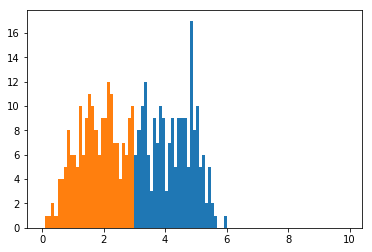

In [20]:
# Plot the distribution of the angles 
tmp=plt.hist(angles, bins=np.arange(0,10,0.1))
tmp=plt.hist(angles[indiceesWithinFoV], bins=np.arange(0,10,0.1))


# Want to examine the sensitivity on "MarginForErrorRadians"
 - I.e., how wide is wide enough (so that we don't keep calculating orbits for no reason) ?

In [21]:
# Start by making a compact version of the analysis performed in the above cells...
def evaluate_pointing( P, deg ):
    # Calculate the approximate HP list with the margin-for-error
    P.HP_covered_by_FoV(MarginForErrorRadians=np.radians(deg))
    
    # Import the Object List for the pointing ...
    obsCode = '500'
    JDUTCstr = str(int(P.JDutc))+"_5"
    OrbitObjectList = mpchecker.OrbitObjectsByHP(P.HPfov , JDUTCstr , obsCode)
    
    # Propagate orbits to time of pointing
    RA_,DEC_=[],[]
    for OO in OrbitObjectList:
        r, d = OO.get_RADEC( np.array([P.JDutc]), P.helio_ec_posn)
        RA_.append(r[0]), DEC_.append(d[0])
        
    # This step not needed ... 
    
    # Get the indicees of the objects which fall within the FoV
    indiceesWithinFoV = P.select_RADEC_within_FoV(RA_, DEC_)
    # Return the number of indicees within the FoV 
    return len(OrbitObjectList), len(indiceesWithinFoV[0])
    

In [24]:
%%time
# Look at some different values of the "MarginForErrorRadians"
# - N.B. I am just printing out the total number of returned objects within the FoV
for deg in [0.0, 0.1, 1.0, 3.0, 10.0]:
    nTot_, nIn_ = [],[]
    for P in PointingList[:123] :  ## <<-- To save time, just doing a subset of the pointings
        _ = evaluate_pointing( P, deg)
        nTot_.append(_[0])
        nIn_.append(_[1])
    print("Margin: ",deg , " , Ncandidates=", np.sum(nTot_), " N_in_Fov=", np.sum(nIn_))

Margin:  0.0  , Ncandidates= 96851  N_in_Fov= 47146
Margin:  0.1  , Ncandidates= 103052  N_in_Fov= 47948
Margin:  1.0  , Ncandidates= 151524  N_in_Fov= 50294
Margin:  3.0  , Ncandidates= 292469  N_in_Fov= 50306
Margin:  10.0  , Ncandidates= 1116409  N_in_Fov= 50306
CPU times: user 1min 39s, sys: 765 ms, total: 1min 40s
Wall time: 38 s


# Get Indicees (of OrbitObjects) within FoV of all Pointings

In [ ]:
%%time
# Advance all OrbitObjects to the times of all (3k?) Pointings
rDict,dDict,iDict={},{},{}
for i,P in enumerate(PointingList):
    RA_, DEC_ = [],[]
    # Get the RA,Dec of each object relevant to the Pointing 
    for OO in OrbitObjectDict[i]:
        r, d = OO.get_RADEC( np.array([P.JDutc]), np.array([P.helio_ec_posn]))
        RA_.append(r)
        DEC_.append(d)
        
    # Get the indicees of the objects which fall within the FoV
    indiceesWithinFoV = P.select_RADEC_within_FoV(RA_, DEC_)
    
    # Save in some handy dicts ...
    rDict[i]=RA_
    dDict[i]=DEC_
    iDict[i]=indiceesWithinFoV


# Examine the output
tmpR, tmpD, tmpC = [],[],[]
for i,P in enumerate(PointingList):
    if i < 2: 
        print(i, P.RADEC, len(iDict[i][0]) )
    tmpR.append(P.RADEC[0])
    tmpD.append(P.RADEC[1])
    tmpC.append(len(iDict[i][0]) )
#plt.scatter(tmpR, tmpD, c=tmpC, cmap='viridis')
#plt.colorbar()

In [ ]:
%%time
# Advance all OrbitObjects to the times of all (500?) Pointings
RA_, DEC_ = [],[]
for OO in OrbitObjectList:
    r, d = OO.get_RADEC( np.array([P.JDutc for P in PointingList]), np.array([P.helio_ec_posn for P in PointingList]))
    RA_.append(r)
    DEC_.append(d)
RA_, DEC_ = np.array(RA_), np.array(DEC_)

# Get the indicees of the objects which fall within the FoV
indiceesWithinFoV = []
for i,P in enumerate(PointingList):
    indiceesWithinFoV.append( P.select_RADEC_within_FoV(RA_[:,i], DEC_[:,i]) )

# Examine the output
tmpR, tmpD, tmpC = [],[],[]
for i,P in enumerate(PointingList):
    if i < 2: 
        print(i, P.RADEC, len(indiceesWithinFoV[i][0]) )
    tmpR.append(P.RADEC[0])
    tmpD.append(P.RADEC[1])
    tmpC.append(len(indiceesWithinFoV[i][0]) )
plt.scatter(tmpR, tmpD, c=tmpC, cmap='viridis')
plt.colorbar()